In [1]:


import benji_utils as utils
import bbbfs_algorithms as bbbfa

import networkit as nk
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from scipy.stats.mstats import winsorize
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

import re

In [3]:
# p = '../M3_ext_val_data/chunglu_scaling/'
p = '../M3_ext_val_data/chunglu_scaling4/'
import glob
dfs = []


algo_name_map = {
    'python-BiBFS_Layerbalanced': 'LB',
    'python-BiBFS_VertexBalancedApproximate': 'VBA',
    'python-BiBFS_ExactExpandSmallerQueue': 'VBSQ',
    'python-BiBFS_ExactCheckDirectEdges': 'VBDE',
    'python-BiBFS_EdgeBalancedApproximate': 'EBA',
}


for fn in glob.glob(p + '*.csv'):
    df = (pd.read_csv(fn))
    df.algo = df.algo.apply(lambda x: algo_name_map[x])
    dfs.append(df)

In [4]:
df = pd.concat(dfs)

In [5]:
infos = {}
for fn in glob.glob(p + '*_info.txt'):
    # name = fn[:fn.index('_info.txt')]
    name = re.match('.*(cl_n.*)_info.txt', fn).group(1)
    with open(fn) as f:
        # print(f.read())
        infos[name] = f.read().split()
        infos[name] = (int(infos[name][0]), int(infos[name][2]))



In [6]:
df_infos = pd.DataFrame(infos).T
df_infos
df_infos.columns = ['n', 'm']
# make index a column called graph
df_infos['graph'] = df_infos.index
df_infos.reset_index(inplace=True, drop=True)
df_infos

,n,m,graph
0,1000,14938,cl_n=1000_deg=30_ple=9.0_seed=1
1,7500,112167,cl_n=7500_deg=30_ple=25.0_seed=3
2,1000,29978,cl_n=1000_deg=60_ple=2.0_seed=4
3,7500,113293,cl_n=7500_deg=30_ple=2.7_seed=4
4,7500,113141,cl_n=7500_deg=30_ple=25.0_seed=2
...,...,...,...
3145,497,2504,cl_n=500_deg=10_ple=2.3_seed=4
3146,500,14677,cl_n=500_deg=60_ple=18.0_seed=1
3147,493,2495,cl_n=500_deg=10_ple=2.3_seed=5
3148,30000,901335,cl_n=30000_deg=60_ple=2.3_seed=2


In [7]:
df = df.merge(df_infos, on='graph', how='left')

In [8]:
import re

df['n_orig'] = df.graph.apply(lambda x: int(re.search('n=(.*?)_', x).group(1)))
df['ple'] = df.graph.apply(lambda x: re.search('ple=(.*?)_', x).group(1))
df['ple'] = df['ple'].astype(float)
df['seed'] = df.graph.apply(lambda x: re.search('seed=(.*?)$', x).group(1))
df['deg'] = df.graph.apply(lambda x: int(re.search('deg=(.*?)_', x).group(1)))


In [9]:
df.groupby(['n_orig', 'deg', 'ple', 'algo']).search_space.median()

n_orig  deg  ple   algo
100     10   2.0   EBA        8.0
                   LB        11.0
                   VBA       11.0
                   VBDE      11.0
                   VBSQ     255.5
                            ...  
80000   60   25.0  EBA      479.5
                   LB       930.5
                   VBA      493.5
                   VBDE    1336.5
                   VBSQ    1645.5
Name: search_space, Length: 3150, dtype: float64

In [10]:
graph_algo_medians = df.groupby(['n_orig', 'deg', 'ple', 'algo']).search_space.median()
graph_algo_medians = graph_algo_medians.reset_index()


In [11]:
graph_m_medians = df.groupby(['n_orig', 'deg', 'ple']).m.median()
graph_m_stds = df.groupby(['n_orig', 'deg', 'ple']).m.std()

graph_algo_medians = graph_algo_medians.merge(graph_m_medians, on=['n_orig', 'deg', 'ple'], how='left')
graph_algo_medians = graph_algo_medians.merge(graph_m_stds, on=['n_orig', 'deg', 'ple'], how='left')
graph_algo_medians.rename(columns={'m_x': 'm', 'm_y': 'm_std'}, inplace=True)

graph_n_medians = df.groupby(['n_orig', 'deg', 'ple']).n.median()
graph_n_stds = df.groupby(['n_orig', 'deg', 'ple']).n.std()
graph_algo_medians = graph_algo_medians.merge(graph_n_medians, on=['n_orig', 'deg', 'ple'], how='left')
graph_algo_medians = graph_algo_medians.merge(graph_n_stds, on=['n_orig', 'deg', 'ple'], how='left')
graph_algo_medians.rename(columns={'n_x': 'n', 'n_y': 'n_std'}, inplace=True)

graph_algo_medians['m_goal'] = graph_algo_medians.deg.astype(int) * graph_algo_medians.n_orig.astype(int) / 2

graph_algo_medians = graph_algo_medians.merge(df.groupby(['n_orig', 'deg', 'ple', 'algo']).search_space.std(), on=['n_orig', 'deg', 'ple', 'algo'], how='left')
graph_algo_medians.rename(columns={'search_space_x': 'search_space', 'search_space_y': 'search_space_std'}, inplace=True)

graph_algo_medians['search_space_fraction'] = graph_algo_medians['search_space'] / graph_algo_medians['m']
# graph_algo_medians.sort_values(['graph', 'algo'], inplace=True)

In [12]:
foo = graph_algo_medians

In [13]:
foo

,n_orig,deg,ple,algo,search_space,m,m_std,n,n_std,m_goal,search_space_std,search_space_fraction
0,100,10,2.0,EBA,8.0,493.0,22.925318,100.0,0.80016,500.0,5.383914,0.016227
1,100,10,2.0,LB,11.0,493.0,22.925318,100.0,0.80016,500.0,12.140973,0.022312
2,100,10,2.0,VBA,11.0,493.0,22.925318,100.0,0.80016,500.0,12.118338,0.022312
3,100,10,2.0,VBDE,11.0,493.0,22.925318,100.0,0.80016,500.0,12.088522,0.022312
4,100,10,2.0,VBSQ,255.5,493.0,22.925318,100.0,0.80016,500.0,198.070667,0.518256
...,...,...,...,...,...,...,...,...,...,...,...,...
3145,80000,60,25.0,EBA,479.5,2399586.0,1497.911899,80000.0,0.00000,2400000.0,256.605564,0.000200
3146,80000,60,25.0,LB,930.5,2399586.0,1497.911899,80000.0,0.00000,2400000.0,1019.397128,0.000388
3147,80000,60,25.0,VBA,493.5,2399586.0,1497.911899,80000.0,0.00000,2400000.0,286.715160,0.000206
3148,80000,60,25.0,VBDE,1336.5,2399586.0,1497.911899,80000.0,0.00000,2400000.0,1060.125492,0.000557


In [14]:
foo.ple.unique()

array([ 2. ,  2.1,  2.3,  2.5,  2.7,  2.9,  3. ,  3.3,  4. ,  6. ,  9. ,
       13. , 18. , 25. ])

In [15]:
foo.loc[(foo.ple==2.5) & (foo.deg==60)]

,n_orig,deg,ple,algo,search_space,m,m_std,n,n_std,m_goal,search_space_std,search_space_fraction
155,100,60,2.5,EBA,14.0,2978.0,26.361297,100.0,0.0,3000.0,7.808694,0.004701
156,100,60,2.5,LB,53.0,2978.0,26.361297,100.0,0.0,3000.0,19.151343,0.017797
157,100,60,2.5,VBA,53.0,2978.0,26.361297,100.0,0.0,3000.0,19.151343,0.017797
158,100,60,2.5,VBDE,53.0,2978.0,26.361297,100.0,0.0,3000.0,19.151343,0.017797
159,100,60,2.5,VBSQ,123.5,2978.0,26.361297,100.0,0.0,3000.0,1881.599983,0.041471
...,...,...,...,...,...,...,...,...,...,...,...,...
3095,80000,60,2.5,EBA,86.0,2399254.0,2258.503030,80000.0,0.0,2400000.0,77.442882,0.000036
3096,80000,60,2.5,LB,72.0,2399254.0,2258.503030,80000.0,0.0,2400000.0,270.987232,0.000030
3097,80000,60,2.5,VBA,74.0,2399254.0,2258.503030,80000.0,0.0,2400000.0,216.071222,0.000031
3098,80000,60,2.5,VBDE,74.0,2399254.0,2258.503030,80000.0,0.0,2400000.0,214.220737,0.000031


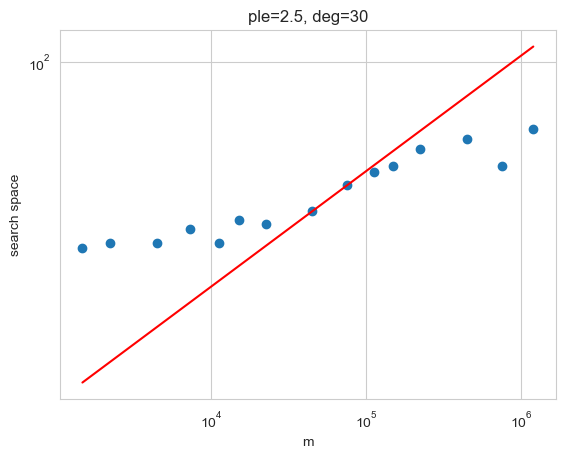

In [16]:
ple = 2.5    
_ = plt.figure()

df_sub = foo.loc[(foo.algo == 'LB') & (foo.ple == ple) & (foo.deg == 30)]
y = df_sub.search_space
x = df_sub.m
_ = plt.scatter(x, y, label='LB')
_ = plt.xlabel('m')
_ = plt.ylabel('search space')
_ = plt.title(f'ple={ple}, deg=30')
plt.xscale('log')
plt.yscale('log')
# insert line of gradient ple that passes through the first point
x_mid = x.median()
i_mid = np.argwhere(x == x_mid).flatten()[0]
y_mid = y.iloc[i_mid]
y2 = x**((ple-2)/(ple-1))
y2 *= y_mid / y2.iloc[i_mid]
_ = plt.plot(x, y2, label='ple', color='red')

# _ = plt.plot(x, x**((ple-2)/(ple-1)), label='ple')

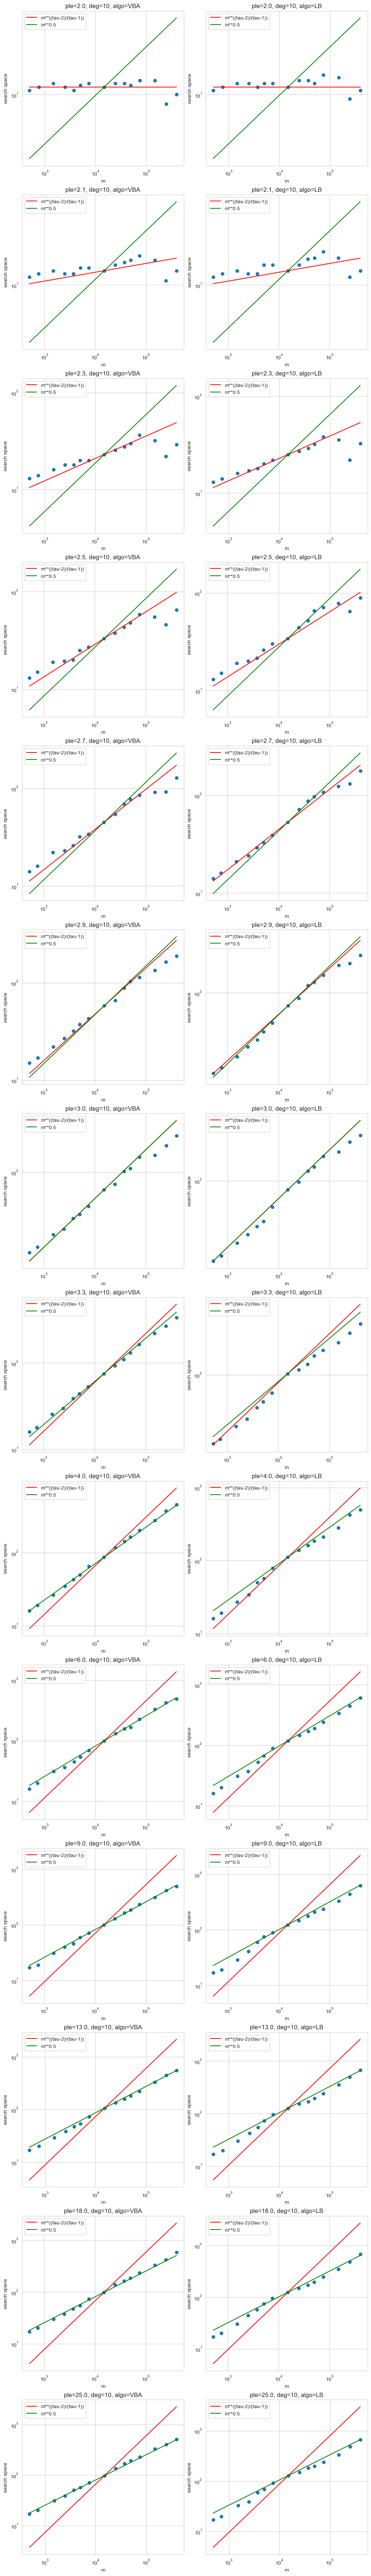

In [27]:
deg = 10
n_rows = len(foo.ple.unique())
fig, axes = plt.subplots(n_rows, 2, figsize=(10, 5 * n_rows), constrained_layout=True)

for row, ple in enumerate(foo.ple.unique()):
    for i, algo in enumerate(['VBA', 'LB']):
        ax = axes[row, i]
        df_sub = foo.loc[(foo.algo == algo) & (foo.ple == ple) & (foo.deg == deg)]
        y = df_sub.search_space
        x = df_sub.m
        ax.scatter(x, y)
        ax.set_xlabel('m')
        ax.set_ylabel('search space')
        ax.set_title(f'ple={ple}, deg={deg}, algo={algo}')
        ax.set_xscale('log')
        ax.set_yscale('log')

        # Insert line of gradient ple that passes through the first point
        x_mid = x.median()
        i_mid = np.argwhere(x == x_mid).flatten()[0]
        y_mid = y.iloc[i_mid]
        y2 = x**((ple-2)/(ple-1))
        y2 *= y_mid / y2.iloc[i_mid]
        ax.plot(x, y2, label='m**((tau-2)/(tau-1))', color='red')

        y3 = x**(0.5)
        y3 *= y_mid / y3.iloc[i_mid]
        ax.plot(x, y3, label='m**0.5', color='green')

        ax.legend()

plt.show()

In [28]:
foo.n_orig.unique()

array([  100,   150,   300,   500,   750,  1000,  1500,  3000,  5000,
        7500, 10000, 15000, 30000, 50000, 80000])

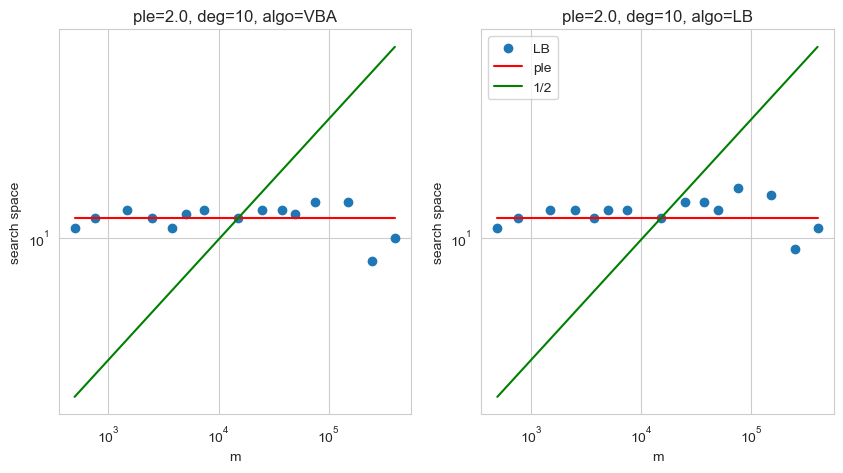

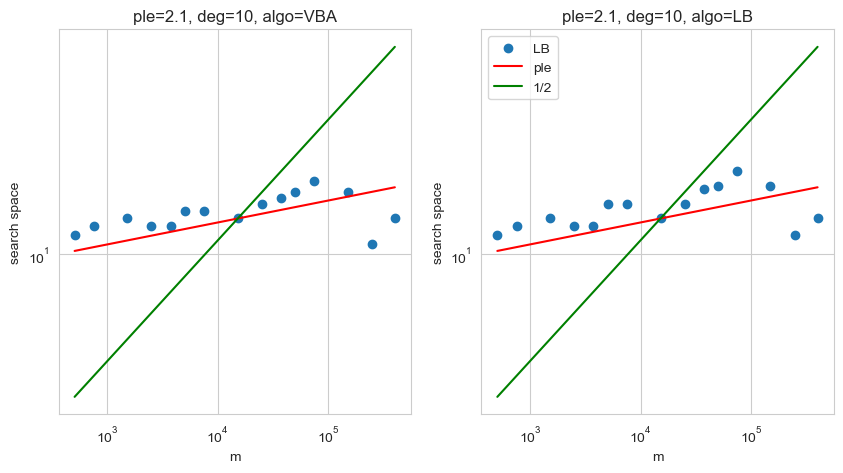

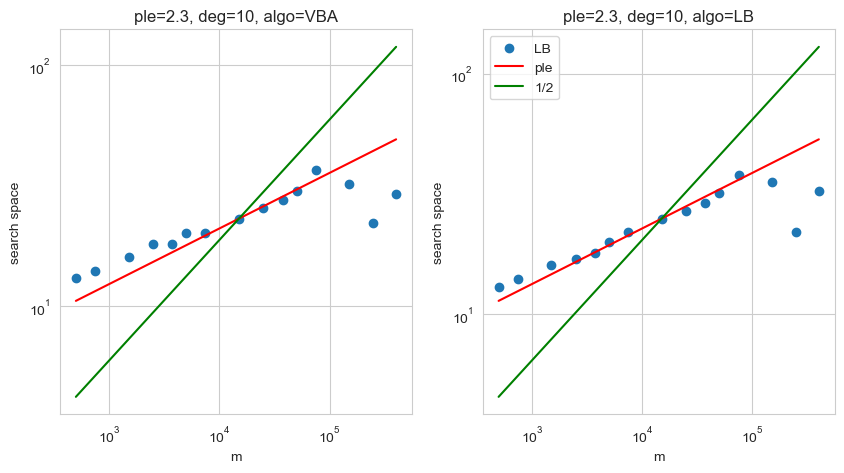

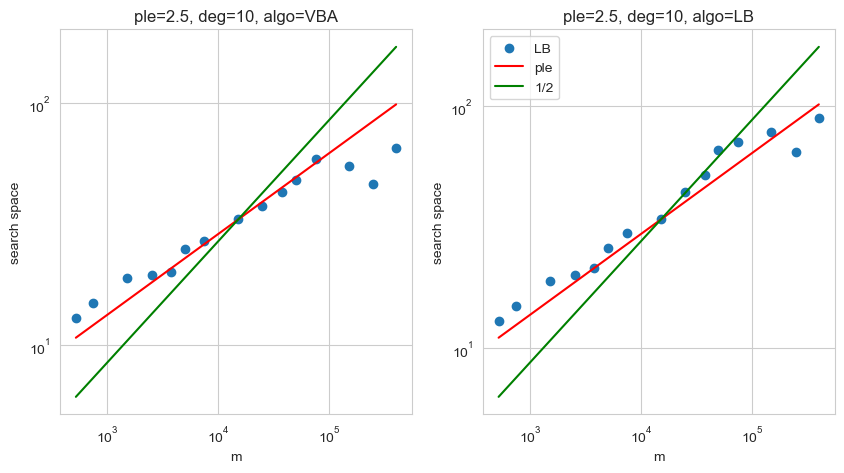

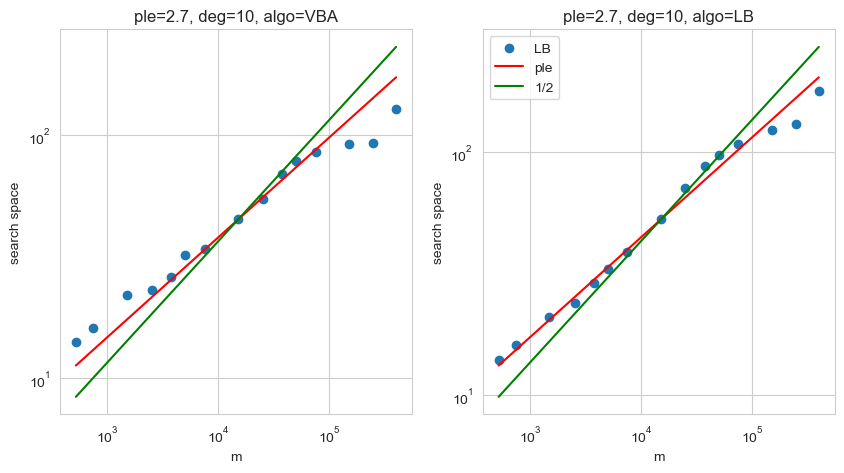

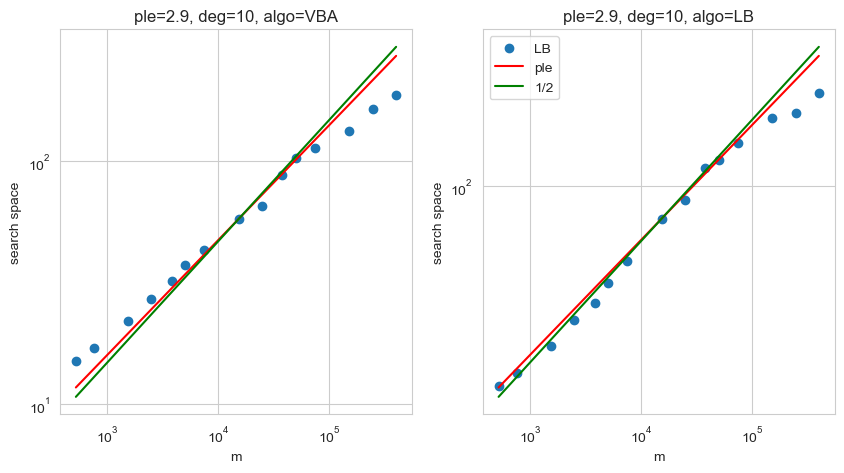

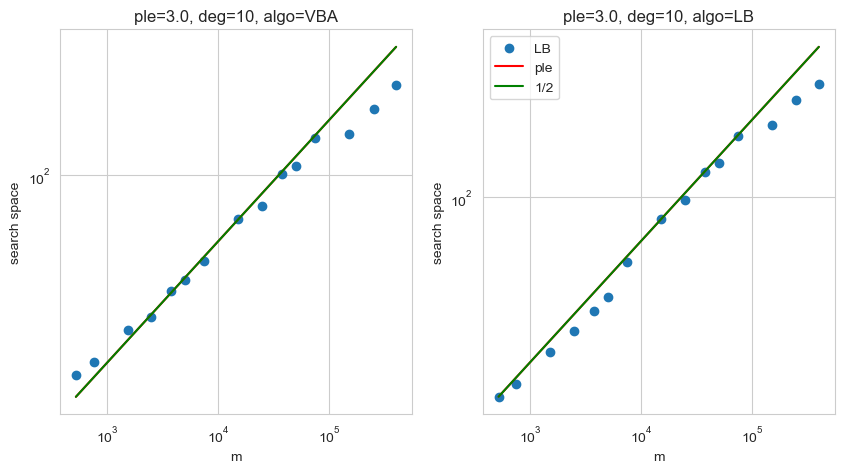

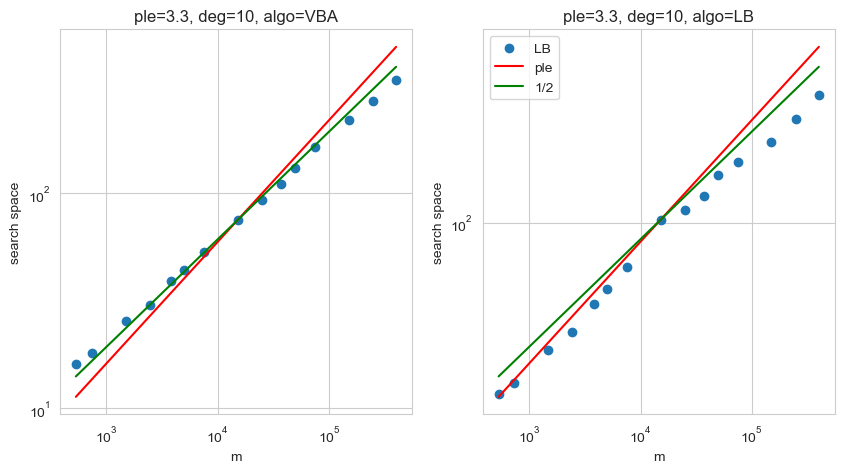

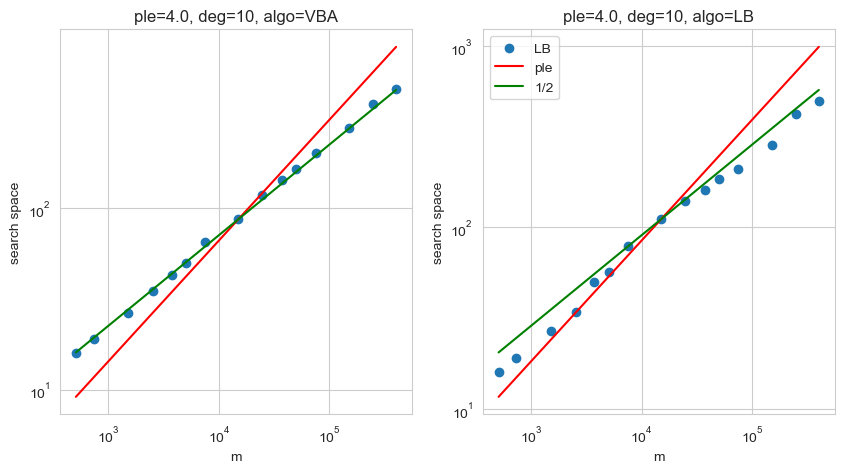

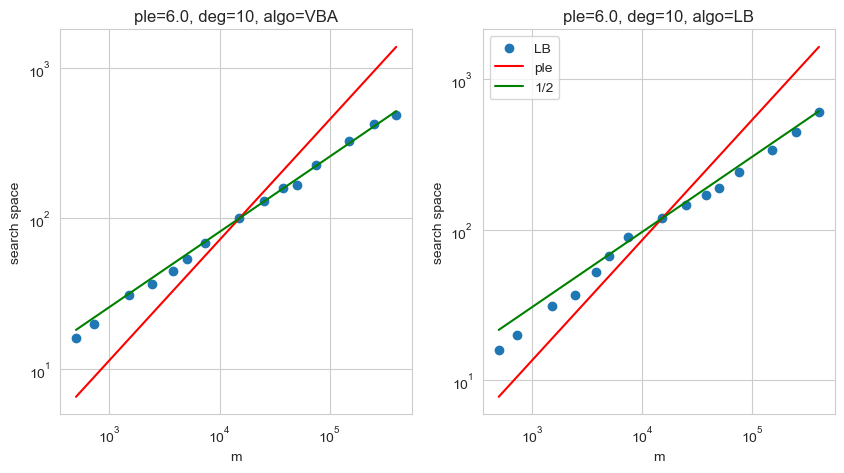

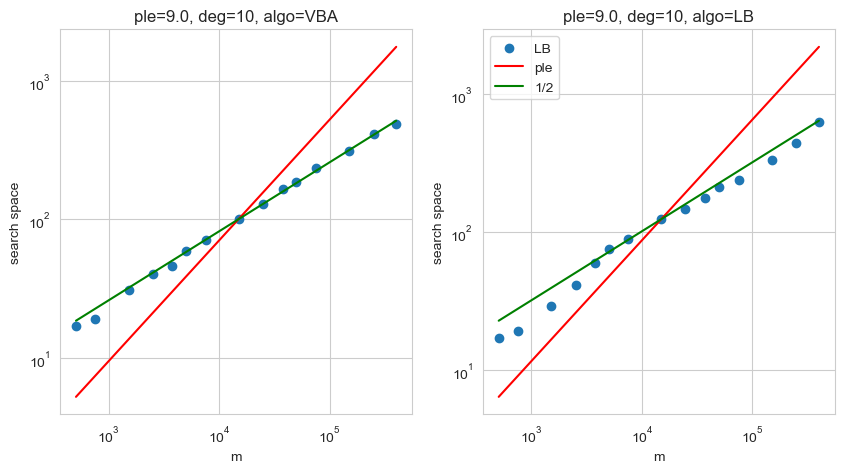

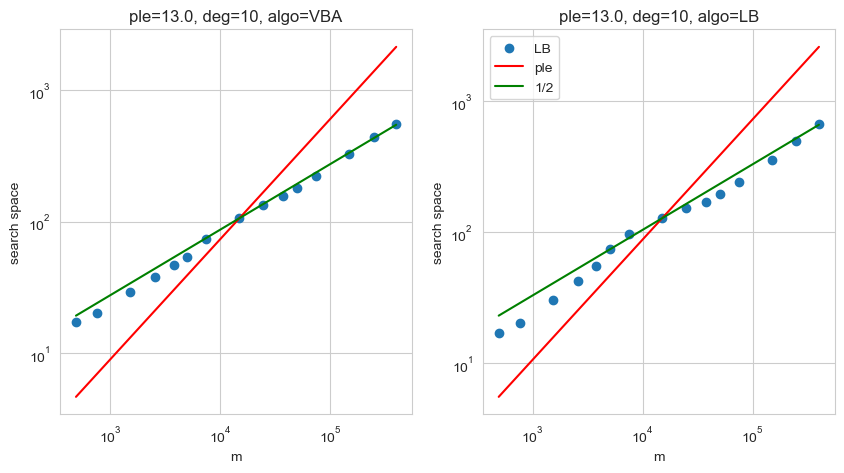

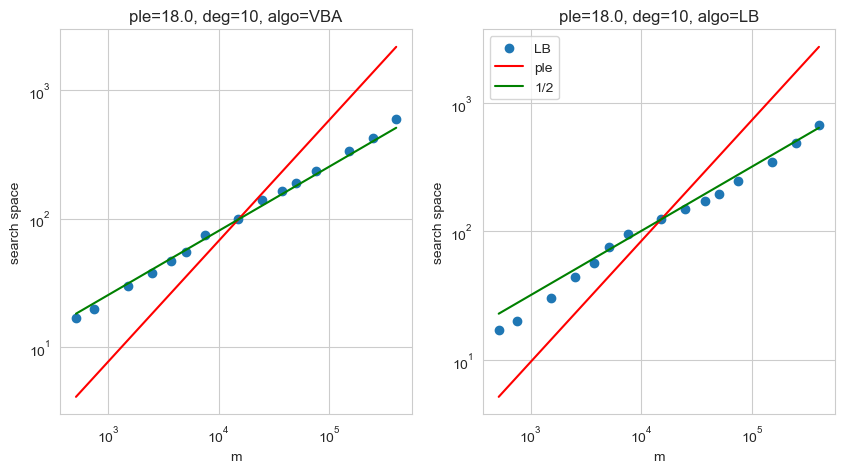

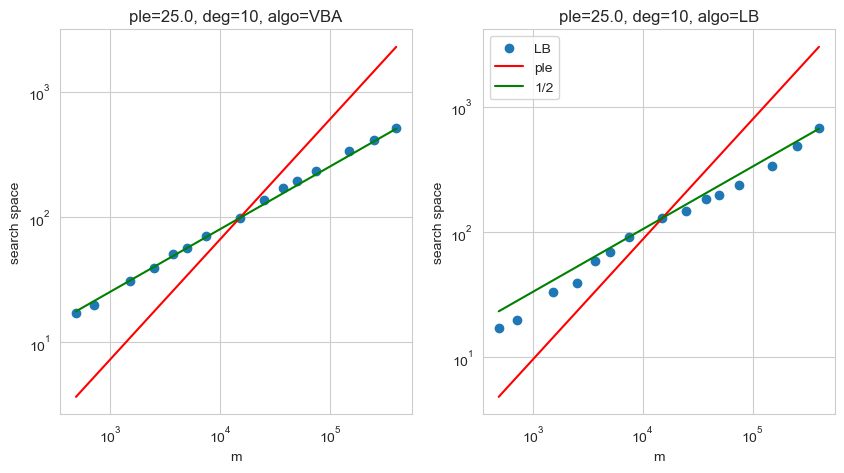

In [22]:
deg = 10
for ple in foo.ple.unique()[:]:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    for i, algo in enumerate(['VBA', 'LB']):
        ax = axes[i]
        df_sub = foo.loc[(foo.algo == algo) & (foo.ple == ple) & (foo.deg == deg)]
        y = df_sub.search_space
        x = df_sub.m
        _ = ax.scatter(x, y, label=algo)
        _ = ax.set_xlabel('m')
        _ = ax.set_ylabel('search space')
        _ = ax.set_title(f'ple={ple}, deg={deg}, algo={algo}')
        ax.set_xscale('log')
        ax.set_yscale('log')
        # insert line of gradient ple that passes through the first point
        x_mid = x.median()
        i_mid = np.argwhere(x == x_mid).flatten()[0]
        y_mid = y.iloc[i_mid]
        y2 = x**((ple-2)/(ple-1))
        y2 *= y_mid / y2.iloc[i_mid]
        _ = ax.plot(x, y2, label='ple', color='red')

        y3 = x**(0.5)
        y3 *= y_mid / y3.iloc[i_mid]
        _ = ax.plot(x, y3, label='1/2', color='green')

    _= plt.legend()
    

In [18]:
foo.n_orig.unique()

array([  100,   150,   300,   500,   750,  1000,  1500,  3000,  5000,
        7500, 10000, 15000, 30000, 50000, 80000])

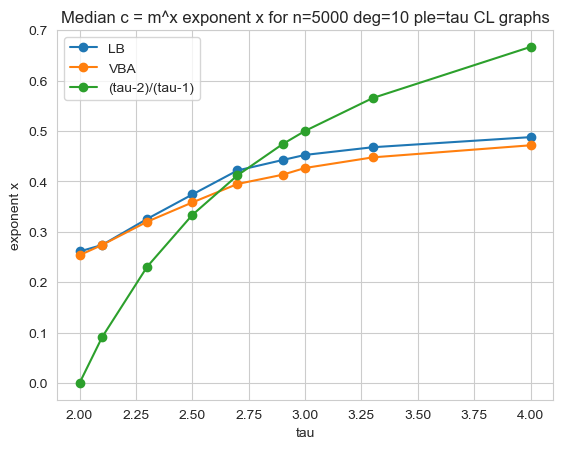

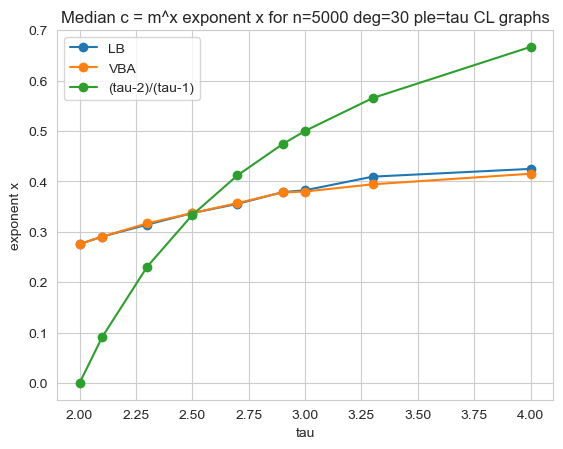

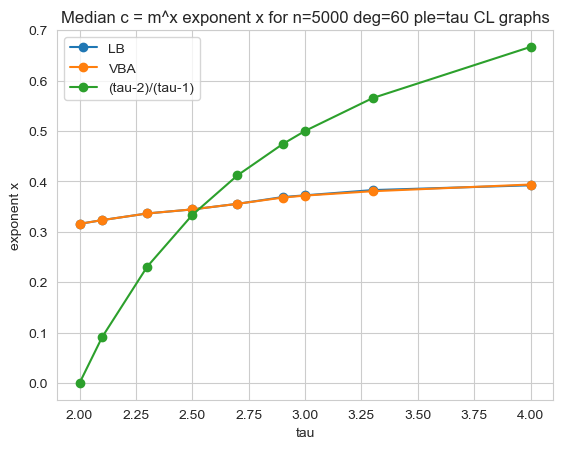

In [30]:
for deg in [10, 30, 60]:
    plt.figure()
    n = 5000

    df_sub = foo.loc[(foo.n_orig == n) & (foo.deg == deg) & (foo.ple <= 4)]

    c = df_sub.loc[df_sub.algo == 'LB'].groupby('ple').search_space.median()
    m = df_sub.loc[df_sub.algo == 'LB'].groupby('ple').m.median()

    plt.plot(c.index, np.log(c.values) / np.log(m.values), label='LB', marker='o')
    plt.plot()

    c = df_sub.loc[df_sub.algo == 'VBA'].groupby('ple').search_space.median()
    m = df_sub.loc[df_sub.algo == 'VBA'].groupby('ple').m.median()
    # actually m should
    plt.plot(c.index, np.log(c.values) / np.log(m.values), label='VBA', marker='o')
    plt.plot()

    # n=400
    tau = c.index
    # y = np.power(n, (tau-2)/(tau-1))
    y = (tau-2)/(tau-1)
    plt.plot(tau, y, label='(tau-2)/(tau-1)', marker='o')
    # plt.xscale('log')
    plt.xlabel('tau')
    plt.legend()
    plt.ylabel('exponent x')
    plt.title(f'Median c = m^x exponent x for n={n} deg={deg} ple=tau CL graphs')

Text(0.5, 1.0, 'Median c = m^x exponent x for n=50000 deg=10 ple=tau CL graphs')

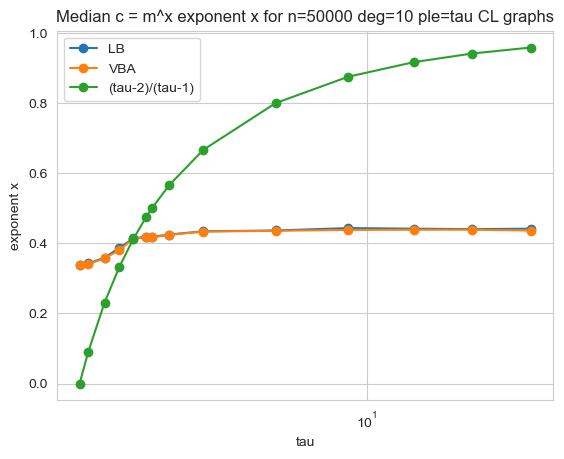

In [101]:
c = foo.loc[foo.algo == 'LB'].groupby('ple').search_space.median()
m = foo.loc[foo.algo == 'LB'].groupby('ple').m.median()
# actually m should
plt.plot(c.index, np.log(c.values) / np.log(m.values), label='LB', marker='o')
plt.plot()

c = foo.loc[foo.algo == 'VBA'].groupby('ple').search_space.median()
m = foo.loc[foo.algo == 'VBA'].groupby('ple').m.median()
# actually m should
plt.plot(c.index, np.log(c.values) / np.log(m.values), label='VBA', marker='o')
plt.plot()

# n=400
tau = c.index
# y = np.power(n, (tau-2)/(tau-1))
y = (tau-2)/(tau-1)
plt.plot(tau, y, label='(tau-2)/(tau-1)', marker='o')
plt.xscale('log')
plt.xlabel('tau')
plt.legend()
plt.ylabel('exponent x')
plt.title('Median c = m^x exponent x for n=50000 deg=10 ple=tau CL graphs')

Text(0.5, 1.0, 'Median c = m^x exponent x for n=50000 deg=10 ple=tau CL graphs')

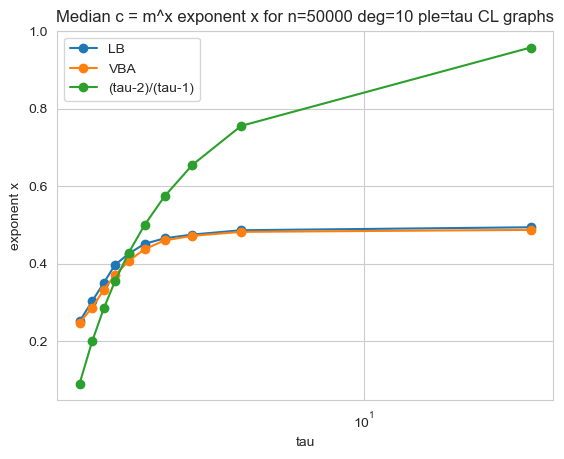

In [60]:
c = foo.loc[foo.algo == 'LB'].groupby('ple').search_space.median()
m = foo.loc[foo.algo == 'LB'].groupby('ple').m.median()
# actually m should
plt.plot(c.index, np.log(c.values) / np.log(m.values), label='LB', marker='o')
plt.plot()

c = foo.loc[foo.algo == 'VBA'].groupby('ple').search_space.median()
m = foo.loc[foo.algo == 'VBA'].groupby('ple').m.median()
# actually m should
plt.plot(c.index, np.log(c.values) / np.log(m.values), label='VBA', marker='o')
plt.plot()

# n=400
tau = c.index
# y = np.power(n, (tau-2)/(tau-1))
y = (tau-2)/(tau-1)
plt.plot(tau, y, label='(tau-2)/(tau-1)', marker='o')
plt.xscale('log')
plt.xlabel('tau')
plt.legend()
plt.ylabel('exponent x')
plt.title('Median c = m^x exponent x for n=50000 deg=10 ple=tau CL graphs')

In [61]:
df

,s,t,algo,search_space,dist,time_dist,graph
0,14005,33500,LB,498,4,0.000306,cl_n=50000_deg=10_ple=2.75_seed=321
1,4490,12178,LB,380,4,0.000208,cl_n=50000_deg=10_ple=2.75_seed=321
2,18229,28981,LB,693,4,0.000387,cl_n=50000_deg=10_ple=2.75_seed=321
3,19326,34770,LB,245,4,0.000143,cl_n=50000_deg=10_ple=2.75_seed=321
4,18120,47486,LB,413,5,0.000308,cl_n=50000_deg=10_ple=2.75_seed=321
...,...,...,...,...,...,...,...
4995,11510,13159,EBA,628,6,0.001417,cl_n=50000_deg=10_ple=25.0_seed=356
4996,37696,44190,EBA,231,5,0.001219,cl_n=50000_deg=10_ple=25.0_seed=356
4997,212,29735,EBA,403,6,0.001578,cl_n=50000_deg=10_ple=25.0_seed=356
4998,11526,45607,EBA,455,6,0.000955,cl_n=50000_deg=10_ple=25.0_seed=356


In [55]:
a

ple
2.10      22.0
2.25      43.0
2.40      78.5
2.55     139.0
2.75     199.5
3.00     273.5
3.35     327.0
3.90     369.0
5.10     424.0
25.00    465.5
Name: search_space, dtype: float64

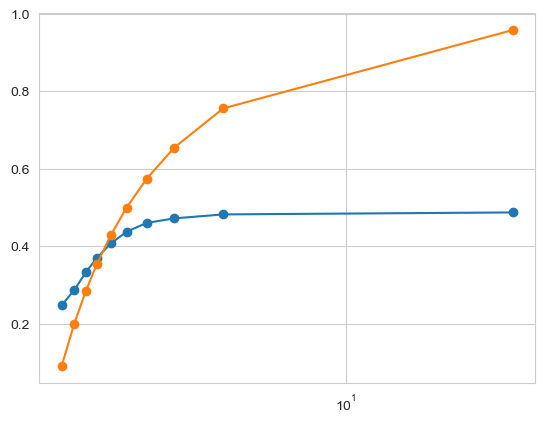

In [52]:
c = foo.loc[foo.algo == 'VBA'].groupby('ple').search_space.median()
m = foo.loc[foo.algo == 'VBA'].groupby('ple').m.median()
# actually m should
plt.plot(a.index, np.log(c.values) / np.log(m.values), label='VBA', marker='o')
plt.plot()

# n=400
tau = a.index
# y = np.power(n, (tau-2)/(tau-1))
y = (tau-2)/(tau-1)
plt.plot(tau, y, label='(tau-2)/(tau-1)', marker='o')
plt.xscale('log')